# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [11]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
fatal: destination path 'detectron2' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [9]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [26]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

In [66]:
#!wget https://img.freepik.com/premium-photo/paintball-camouflage-team-playing-match-fun-fitness-extreme-sports-with-guns-army-weapons-group-military-people-practicing-training-game-outdoor-battlefield_590464-144857.jpg?w=1380 -q -O input.jpg
im = cv2.imread("./paintball.jpg")
#cv2_imshow(im)

### Mask R-CNN

In [81]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[11/10 17:42:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[Checkpointer] Loading from /home/xonizero/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'


In [82]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 7, 0, 7, 8], device='cuda:0')
Boxes(tensor([[ 776.7612,  143.6220,  881.7626,  263.7184],
        [ 527.0676,  333.1828,  923.5996,  673.8385],
        [ 504.7253,  202.4094,  666.0463,  508.9913],
        [ 867.3209,  166.8641,  969.7626,  323.3819],
        [ 242.5273,  293.2570,  570.5355,  808.0771],
        [1041.1499,  115.3969, 1380.0000,  513.9803],
        [ 526.7341,  208.7133,  671.9009,  366.7841],
        [ 179.9369,  213.2944,  683.9177,  438.7848],
        [1037.3777,  140.0909, 1380.0000,  494.6801]], device='cuda:0'))


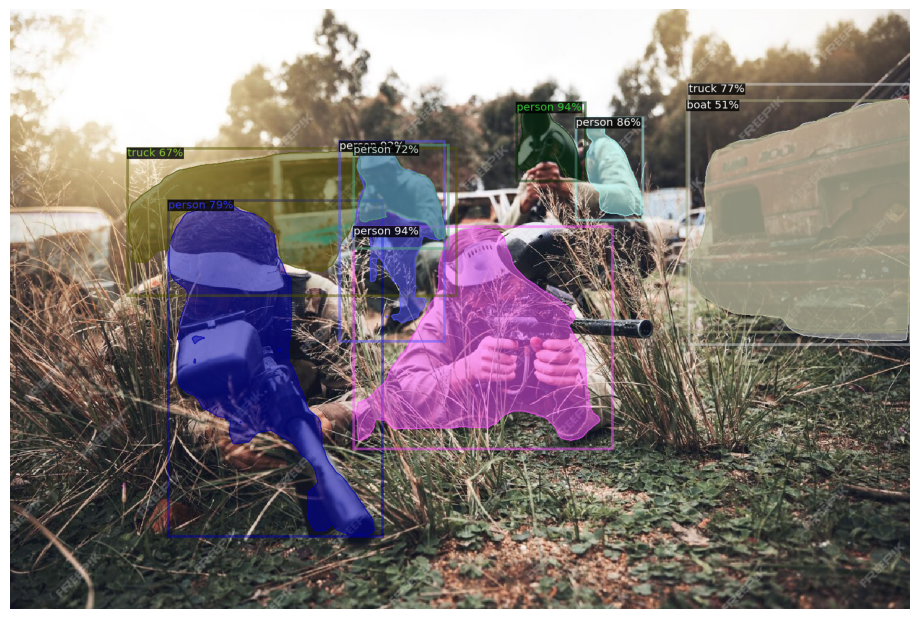

In [83]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Calculate aspect ratio of the image
height, width, _ = image.shape
aspect_ratio = width / height

# Create a figure with a specific size that matches the image aspect ratio
plt.figure(figsize=(aspect_ratio * 6, 6))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove the white space
plt.show()  # Display the image

### Faster R-CNN

[11/10 17:42:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/137257644/model_final_721ade.pkl ...
[Checkpointer] Loading from /home/xonizero/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_R_50_C4_1x/137257644/model_final_721ade.pkl ...
Reading a file from 'Detectron2 Model Zoo'


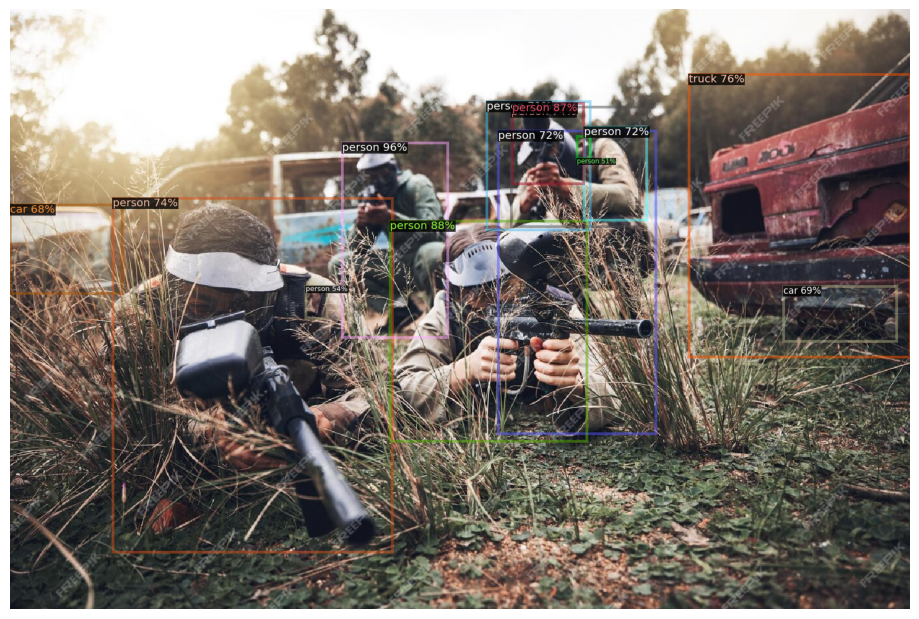

In [84]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")) 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Calculate aspect ratio of the image
height, width, _ = image.shape
aspect_ratio = width / height

# Create a figure with a specific size that matches the image aspect ratio
plt.figure(figsize=(aspect_ratio * 6, 6))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove the white space
plt.show()  # Display the image

### RetinaNet

Loading config /home/xonizero/Documents/USU/CS5510/cs5510-midterm/problem8/detectron2/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[11/10 17:42:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl ...
[Checkpointer] Loading from /home/xonizero/.torch/iopath_cache/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/190397697/model_final_971ab9.pkl ...
Reading a file from 'Detectron2 Model Zoo'


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


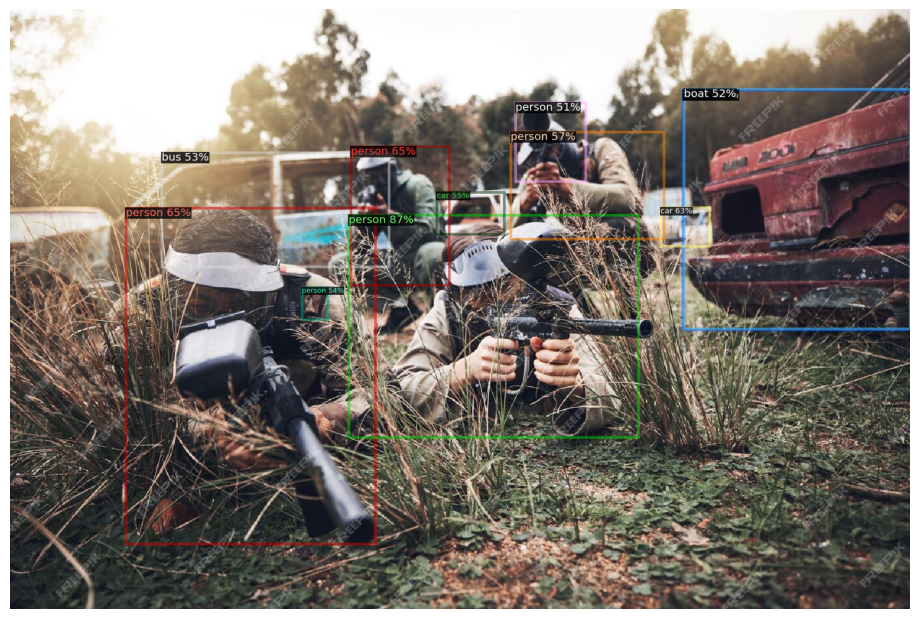

In [85]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

# Calculate aspect ratio of the image
height, width, _ = image.shape
aspect_ratio = width / height

# Create a figure with a specific size that matches the image aspect ratio
plt.figure(figsize=(aspect_ratio * 6, 6))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.tight_layout(pad=0)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove the white space
plt.show()  # Display the image